# TensorFlow implementation for Variational Auto-Encoders (VAEs) using MNIST dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
# a function for visualizing batch images
def VisConcatImg(batch_images, title):
    batch_size = np.shape(batch_images)[0]
    sqrt_size = int(batch_size ** 0.5)
    batch_images = batch_images.reshape(batch_size, 28, 28)
    row_concatenated = [np.concatenate(batch_images[i*sqrt_size : (i+1)*sqrt_size], axis=1) for i in range(sqrt_size)]
    concatenated = np.concatenate(row_concatenated, axis=0)
    plt.imshow(concatenated, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

## Dataset

The MNIST includes 60000 training samples and 10000 testing samples. Each sample is a 784-dimensional vector (28×28), with pixel values in [0, 1], which can be assumed as multivariate Bernoulli variables.

In [3]:
"""
downloading MNIST dataset
"""
mnist = input_data.read_data_sets('./mnist', one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/train-labels-idx1-ubyte.gz
Extracting ./mnist/t10k-images-idx3-ubyte.gz
Extracting ./mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## Model:

In variational auto-encoders, neural networks are used as probabilistic encoders and decoders.
There are many possible choices of encoders and decoders, depending on the type of data and model.
In our example we used a MLP with Gaussian output, while for the decoder we used MLPs with Bernoulli output.

Prior distribution: $p_{\boldsymbol \theta}({\mathbf z})= \mathcal{N}({\mathbf z}; {\mathbf 0}, {\mathbf I})$.

For MNIST dataset, we can use a Bernoulli MLP as decoder: $p_{\boldsymbol \theta}({\mathbf x}|{\mathbf z})=\prod_{i=1}^D y_i ^{x_i} (1-y_i)^{1 - x_i}$ where ${\mathbf y} = \mathrm{DecoderNeuralNet}_{\boldsymbol \theta}({\mathbf z})$.

A Gaussian MLP as encoder: $q_{\boldsymbol \phi}({\mathbf z}|{\mathbf x}) = \mathcal{N}({\mathbf z}; {\boldsymbol \mu}, \mathrm{diag}({\boldsymbol \sigma}^2))$ where $({\boldsymbol \mu}, {\boldsymbol \sigma}) = \mathrm{EncoderNeuralNet}_{\boldsymbol \phi}({\mathbf x})$.

Unbiased estimator of ELBO:
$$\mathcal{L}_{{\boldsymbol \theta}, {\boldsymbol \phi}}({\mathbf x}) \simeq \log p_{\boldsymbol \theta}({\mathbf x}|{\mathbf z})+\dfrac{1}{2}\sum_{j=1}^J\left(1+\log((\sigma_j)^2)-(\mu_j)^2 - (\sigma_j)^2\right)$$
 where ${\mathbf z} = {\boldsymbol \mu} + {\boldsymbol \sigma}\odot{\boldsymbol \epsilon}, {\boldsymbol \epsilon} \sim \mathcal{N}({\mathbf 0}, {\mathbf I})$ using reparameterization trick.

In [4]:
"""
VAE for MNIST
"""
class VAE(object):
    def __init__(self, x_size=28*28, hidden1_size=100, hidden2_size=400, hidden3_size=100, hidden4_size=400, z_size=20, learning_rate=1e-4):
        self.x_size = x_size
        self.hidden1_size = hidden1_size
        self.hidden2_size = hidden2_size
        self.hidden3_size = hidden3_size
        self.hidden4_size = hidden4_size
        self.z_size = z_size
        self.learning_rate = learning_rate
        self.x = tf.placeholder(tf.float32, [None, x_size])
        self.epsilon = tf.placeholder(tf.float32, [None, z_size]) # sample from N(0,1) for every step
        with tf.variable_scope('encoder'):
            self.encoder()
        with tf.variable_scope('decoder'):
            self.decoder()
        with tf.variable_scope('loss'):
            self.compute_loss()
        with tf.variable_scope('train'):
            self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.total_loss)

    def encoder(self):
        self.hidden1 = tf.layers.dense(self.x, units=self.hidden1_size, activation=tf.nn.relu)
        self.hidden2 = tf.layers.dense(self.hidden1, units=self.hidden2_size, activation=tf.nn.relu)
        self.mu = tf.layers.dense(self.hidden2, units=self.z_size)
        self.sigma = tf.layers.dense(self.hidden2, units=self.z_size, activation=tf.exp)
        self.z = tf.add(self.mu, tf.multiply(self.epsilon, self.sigma))

    def decoder(self):
        self.hidden3 = tf.layers.dense(self.z, units=self.hidden3_size, activation=tf.nn.relu)
        self.hidden4 = tf.layers.dense(self.hidden3, units=self.hidden4_size, activation=tf.nn.relu)
        self.y = tf.layers.dense(self.hidden4, units=self.x_size, activation=tf.nn.sigmoid)
        
    # adding 1e-8 before taking the logarithm to avoid numerical instability.
    def compute_loss(self):
        self.recons_loss = tf.reduce_mean(tf.reduce_sum(-(self.x * tf.log(self.y + 1e-8) + (1 - self.x) * tf.log(1 - self.y + 1e-8)), 1))
        self.KL_loss = tf.reduce_mean(-0.5 * tf.reduce_sum(1 + 2 * tf.log(self.sigma + 1e-8) - tf.square(self.mu) - tf.square(self.sigma), 1))
        self.total_loss = self.recons_loss + self.KL_loss

In [5]:
"""
training VAE
"""
model = VAE()
BATCH_SIZE = 100
EPOCHS = 50
STEPS = int(60000 / BATCH_SIZE)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
for e in range(EPOCHS):
    for i in range(STEPS):
        train_data, _ = mnist.train.next_batch(batch_size=BATCH_SIZE)
        ep = np.random.multivariate_normal(np.zeros(model.z_size), np.eye(model.z_size), size=BATCH_SIZE)
        sess.run(model.train_op, feed_dict={model.x: train_data, model.epsilon: ep})
    REloss, KLloss, Tloss = sess.run([model.recons_loss, model.KL_loss, model.total_loss],
                                     feed_dict={model.x: train_data, model.epsilon: ep})
    print('Epoch: ', e, '| reconstruction loss: ', REloss, '| KL loss:', KLloss, '| total loss: ', Tloss)

Epoch:  0 | reconstruction loss:  186.6642 | KL loss: 6.4270177 | total loss:  193.09122
Epoch:  1 | reconstruction loss:  159.49005 | KL loss: 11.376843 | total loss:  170.8669
Epoch:  2 | reconstruction loss:  138.21092 | KL loss: 12.689927 | total loss:  150.90085
Epoch:  3 | reconstruction loss:  130.3225 | KL loss: 15.483137 | total loss:  145.80563
Epoch:  4 | reconstruction loss:  127.84584 | KL loss: 16.076818 | total loss:  143.92265
Epoch:  5 | reconstruction loss:  112.36454 | KL loss: 17.663021 | total loss:  130.02756
Epoch:  6 | reconstruction loss:  116.6976 | KL loss: 18.53427 | total loss:  135.23187
Epoch:  7 | reconstruction loss:  108.862305 | KL loss: 19.43758 | total loss:  128.29988
Epoch:  8 | reconstruction loss:  102.13724 | KL loss: 20.59237 | total loss:  122.72961
Epoch:  9 | reconstruction loss:  101.570274 | KL loss: 20.03852 | total loss:  121.608795
Epoch:  10 | reconstruction loss:  101.95042 | KL loss: 21.483189 | total loss:  123.43361
Epoch:  11 | r

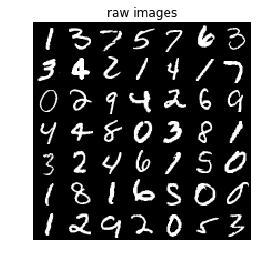

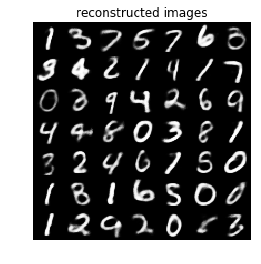

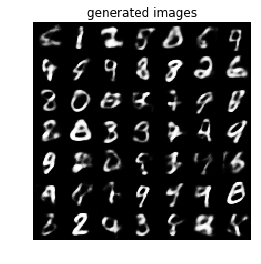

In [7]:
"""
visualizing results
"""
test_data, _ = mnist.test.next_batch(batch_size=50)
VisConcatImg(test_data, 'raw images')

ep = np.random.multivariate_normal(np.zeros(model.z_size), np.eye(model.z_size), size=50)
latent, recons_x = sess.run([model.mu, model.y], feed_dict={model.x: test_data, model.epsilon: ep})
VisConcatImg(recons_x, 'reconstructed images')

randoms = np.random.multivariate_normal(np.zeros(model.z_size), np.eye(model.z_size), size=50)
generated_x = sess.run(model.y, feed_dict={model.z: randoms})
VisConcatImg(generated_x, 'generated images')

In [8]:
sess.close()

## Reference:
Kingma D P, Welling M. Auto-encoding variational bayes[J]. arXiv preprint arXiv:1312.6114, 2013.

Kingma D P. Variational inference & deep learning: A new synthesis[J]. 2017.